Let's generate some data!

In [123]:
import datetime, numpy, random, pandas

def generate_time_series(k=300, m=1000, n=1000, start_date=datetime.date(2017, 1, 1)):
    xs = numpy.linspace(0, 1, n, endpoint=False)
    ys = [k*x + m + random.gauss(0, 500) for x in xs]
    ts = [start_date + datetime.timedelta(x)*365 for x in xs]
    return pandas.DataFrame({'t': ts, 'y': ys})

def generate_logistic_data(k=0.1, m=0.3, n=1000):
    from scipy.special import expit
    def bernoulli(z): return float(random.random() < z)
    xs = [random.gauss(0, 1) for _ in range(n)]
    ys = [bernoulli(expit(k*x + m)) for x in xs]
    return pandas.DataFrame({'x': xs, 'y': ys})

d = generate_time_series()

Let's plot to see what's going on!

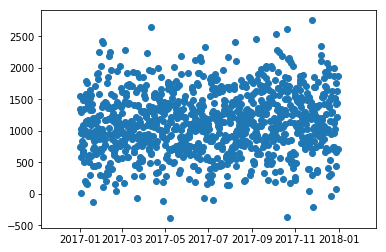

In [124]:
from matplotlib import pyplot
pyplot.scatter(list(d['t']), d['y'])  # not sure why i have to convert it to a list?
pyplot.show()

First of all, let's not fit any fancy models. We're just going to break it up into a few buckets and compute the mean within each bucket. But let's first pause and talk about uncertainty.

# Distribution of the data vs uncertainty

This makes me sometimes feel dumb but I keep confusing what "uncertainty" means and I think it's important to be hyper clear because we're going to do all of them. Let's say we're trying to understand quantity sold as a function of cost. There's multiple different things we can estimate the distribution for:

1. The data itself. Given a certain cost $x$, what's the distribution of outcomes in the data
2. The uncertainty of some parameter, like the parameter $k$ in a linear relationship $y = kx + m$.
3. The uncertainty of predicted quantities. So if we predict that for a cost $x$ then we're going to sell quantity $y$, we want to know the uncertainty of the quantity $y$.

Hope that makes sense! Let's start with the most basic model – just break things up in buckets.

In [128]:
d['month'] = d['t'].apply(lambda t: t.strftime('%Y-%m'))

I recommend the excellent Seaborn package if we just want to get some basic idea of distributions and uncertainty estimates:

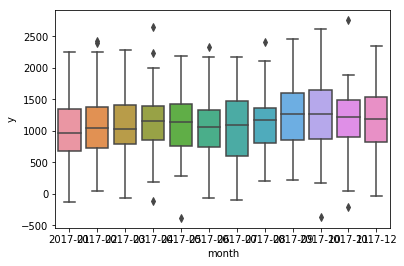

In [129]:
import seaborn
seaborn.boxplot(data=d, x='month', y='y')

Goofing around a bit with Seaborn is fun and you can use other plots like swarmplot:

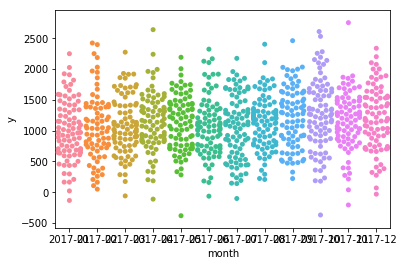

In [130]:
seaborn.swarmplot(data=d, x='month', y='y')

These last charts show the _distribution_ of the dataset.
If for whatever reason we want to compute the uncertainty of the average, turns out that Seaborn actually does that for barcharts:

/Users/erikbern/uncertainty/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


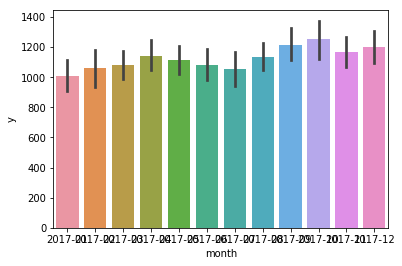

In [131]:
seaborn.barplot(data=d, x='month', y='y')

OK! enough fooling around with Seaborn. If we actually wanted to compute the uncertainty estimates ourselves, how would we do that?

Under some mild assumptions (I'm going to get back to this in a sec and scrutinize it), we can compute the confidence intervals as:

$\bar{x} \pm 1.96\sigma / \sqrt{n}$

Where $\bar{x}$ is the mean and $\sigma$ is the standard deviation, a.k.a. the square root of the variance. I don't think this formula is super important to remember, but I think it's somewhat useful to remember that the _size of the confidence interval is inversely related to the square root of the number of samples._ For instance, this is useful when you're running an A/B test – if you want to detect a 1% difference then you need something on the order of $0.01^{-2} = 10,000$ samples.

Let's compute this ourselves and split it (rather than relying on Seaborn):

In [132]:
# code here...

I mentioned earlier that the formula for confidence interval only applies under some mild assumptions. What are those? It's the assumption of _normality_. For a large number of observations, this is nothing to worry about, and this is due to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

There's one particular case of non-normality that I think is worth remembering. Consider the case when you're measuring something like a "conversion rate" – $k$ out of $n$ converted. Using the "off the shelf" formula for confidence intervals, you might get weird ones that go below 0% or above 100%. The confidence interval of a "$k$ out of $n$" scenario is much better handled using a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). I've personally benefitted from memorizing the formula for the confidence interval and think I probably use it more than the previous (Normal based) one. In particular all you need to remember is

In [ ]:
scipy.stats.ppf([0.025, 0.975], n, n-k)

This will compute a 95% confidence interval if you plug in values for $n$ and $k$.

## Bootstrapping

Another approach that can be useful is bootstrapping. It allows you do compute the same statistics without memorizing any formulas.

# Regression

Let's crank it up a notch. We're going to fit a linear regression to this bad boy.

In [63]:
import scipy.optimize, autograd
from autograd.scipy.special import expit
from autograd.numpy import log

def loss(args):
    k, m = args
    return -sum(y * log(expit(k*x+m)) + (1-y) * log(1-expit(k*x+m)) for x, y in zip(xs, ys))


k_hat, m_hat = scipy.optimize.minimize(loss, (0, 0), jac=autograd.grad(loss)).x

Now that we have a way to fit a model to data, let's reconstruct the original data by fitting a model on everything!

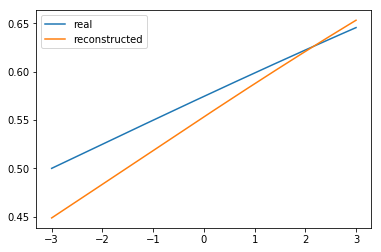

In [64]:
xs_plot = numpy.linspace(-3, 3, 1000)
pyplot.plot(xs_plot, expit(xs_plot*k + m), label='real')
pyplot.plot(xs_plot, expit(xs_plot*k_hat + m_hat), label='reconstructed')
pyplot.legend()